# Experiment: Batch Normalization vs Dropout Regularization.


In the following experiment we will study the impact of <b>batch normalization and dropout on ConvNet to reduce the loss (error)</b>

###setup:

- We will define a model where we have a choice to insert batch norm or dropout after a convolutional layer.
- We will train each variant model on the **Cifar100 dataset**.
- Visualize the differences in validation loss between results of model with dropout, with batch normalization, and with nothing.

- Then , repeat the same steps  by changing the locations of dropout and batch norm layers between convolutions (before, after activation functions & after maxpool).

<b>Tips:</b>  We first place Batch Normalization & Dropout operations before activations, then after activations, and finally after max pooling layers.



###Cifar100 dataset:
This dataset has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class.


## Experiment Setup


### Base Convolutional Layer
These same successive conv layers will be always used in all built models below, they called "conv block"

<img src="https://github.com/harrisonjansma/Research-Computer-Vision/blob/master/08-12-18%20Batch%20Norm%20vs%20Dropout/images/convblock.png?raw=1" height = 250>

Each model is based on the same architecure consisting of 5 convolutional blocks, and it concludes with a single fully connected layer, containing 100 units and softmax activation.

### Architecture Variants
Within each convolutional block we will place either a dropout layer, batch normalization, or nothing (control) at the same place within the convolutional block.


For example, in the first section we place a Batch norm and dropout operation before activation functions. This makes each of the above Conv2D(3x3, ReLU) layers take this architecture :

<img src="https://github.com/harrisonjansma/Research-Computer-Vision/blob/master/08-12-18%20Batch%20Norm%20vs%20Dropout/images/Variants.png?raw=1">

### Dropout Impact
To test the effect of dropout, we will build same three models with different dropout rates: either 0.5, 0.3, or 0.1.

### Conclusion
<b>To conclude, in each section we will train and test a control network, a batch-normalized network, and three dropout networks (with rates of 0.5, 0.3, or 0.1), </b> and compare between their results of accuracy and loss.
We will plot every result and comment our comparison




### Imports

In [ ]:
import tensorflow as tf
import numpy as np
import os

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import img_to_array,array_to_img,load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.models import Model, Sequential
from keras.layers import Input

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers import Activation
from keras.layers import Conv2D, MaxPooling2D, Dense
from keras.layers import MaxPooling2D, Dropout, Flatten

import time

In [ ]:
!pip install np_utils

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for np_utils: filename=np_utils-0.6.0-py3-none-any.whl size=56439 sha256=d1341fa3646892625806ec24123d4277ed1b781f728ad38abc6f1a6a8f4c445f
  Stored in directory: /root/.cache/pip/wheels/b6/c7/50/2307607f44366dd021209f660045f8d51cb976514d30be7cc7
Successfully built np_utils


### Data Loading and Preprocessing.

In [ ]:
from keras.datasets import cifar100
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode='fine')

#scale and regularize the dataset inputs
x_train = (x_train-np.mean(x_train))
x_test = (x_test - x_test.mean())

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#onehot encode the target classes
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


train_datagen = ImageDataGenerator()
train_generator = train_datagen.flow(x_train,
                                     y = y_train,
                                    batch_size=80,
                                    shuffle=True,
                                    )


169001437/169001437 [==============================] - 2s 0us/step


In [ ]:
y_train.shape

# Dropout and Batch Norm before Activations

### Model Construction

In [ ]:
def input_conv_block(model, bn=False, dropout=False, rate=0.4, activation="relu"):
    """
    The first convolutional block in each architecture. Seperated so we can
    specify the input shape.
    """
    model.add(Conv2D(60,3, padding = "same", input_shape = x_train.shape[1:]))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))
    model.add(Activation(activation))

    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))
    model.add(Activation(activation))

    model.add(MaxPooling2D())
    return model

def conv_block(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    Generic convolutional block with 2 stacked 3x3 convolutions, max pooling, dropout,
    and an optional Batch Normalization.
    """
    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))
    model.add(Activation(activation))

    model.add(Conv2D(60,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))
    model.add(Activation(activation))
    model.add(MaxPooling2D())
    return model

def conv_block_final(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    I bumped up the number of filters in the final block. I made this seperate so that
    I might be able to integrate Global Average Pooling later on.
    """
    model.add(Conv2D(100,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))
    model.add(Activation(activation))

    model.add(Conv2D(100,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))
    model.add(Activation(activation))

    model.add(Flatten())
    return model

def fn_block(model):
    """
    build a very deep fully connected block.
    """
    model.add(Dense(1000, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = "softmax"))
    return model

def build_model(blocks=3, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    Builds a sequential network based on the specified parameters.

    blocks: number of convolutional blocks in the network, must be greater than 2.
    bn: whether to include batch normalization or not.
    activation: activation function to use throughout the network.
    """
    model = Sequential()

    model = input_conv_block(model, bn=bn, dropout=dropout, rate=rate, activation=activation)

    for block in range(1,blocks-1):
        model = conv_block(model, bn=bn, dropout=dropout, rate=rate, activation = activation)

    model = conv_block_final(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    model = fn_block(model)

    return model

def compile_model(model, optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]):
    """
    Compiles a neural network.

    model: the network to be compiled.
    optimizer: the optimizer to use.
    loss: the loss to use.
    metrics: a list of keras metrics.
    """
    model.compile(optimizer = optimizer,
                 loss = loss,
                 metrics = metrics)
    return model

### Compile Models

Now, we build the entire model, making 5 versions:

- control object: to build an architecture of 5 blocks without dropout, without BN
- batchNorm: to build an architecture of 5 blocks without dropout, with BN operation
- dropout5: to build an architecture of 5 blocks with a dropout of rate =0.5, without BN operation

- dropout3: to build an architecture of 5 blocks with a dropout of rate =0.3, without BN operation

- dropout1: to build an architecture of 5 blocks with a dropout of rate =0.1, without BN operation

Each time we build a new model object we need to compile it


In [ ]:
control = build_model(blocks = 5, bn=False, dropout=False, activation = "relu")
control = compile_model(control)

batchNorm = build_model(blocks = 5, bn=True, dropout=False, activation = "relu")
batchNorm = compile_model(batchNorm)

dropout5 =  build_model(blocks = 5, bn=False, dropout=True,rate = 0.5, activation = "relu")
dropout5 = compile_model(dropout5)

dropout3 = build_model(blocks = 5, bn=False, dropout=True,rate = 0.3, activation = "relu")
dropout3 = compile_model(dropout3)

dropout1 = build_model(blocks = 5, bn=False, dropout=True, rate=0.1, activation = "relu")
dropout1 = compile_model(dropout1)

## Train the Models

In [ ]:
def trainModel(model, savedest):
    start = time.time()
    #savedest is the path of saved model that you decide to save the model on
    model_checkpoint = ModelCheckpoint(savedest,save_best_only = True)  # this confis will save the model when it gets the best performance

    history = model.fit(
        train_generator,
        steps_per_epoch=625,
        epochs=10,
        verbose=1,
        validation_data = (x_test, y_test),
        callbacks = [model_checkpoint])

    end = time.time()

    print("Training time: ", (end - start)/60, " minutes")
    return history

def plotModel(history, modelname):
    plt.figure(figsize=(12,6))
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(modelname+' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(modelname+' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    return None

def plotAllModels(history1, history2, history3, history4, history5, title):
    plt.figure(figsize=(12,6))
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history1.history['val_accuracy'])
    plt.plot(history2.history['val_accuracy'])
    plt.plot(history3.history['val_accuracy'])
    plt.plot(history4.history['val_accuracy'])
    plt.plot(history5.history['val_accuracy'])
    plt.title(title + ' Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Control', 'Batch Norm', 'Dropout (0.5)', 'Dropout (0.3)', 'Dropout (0.1)'], loc='upper left')
    # summarize history for loss
    plt.subplot(122)
    plt.plot(history1.history['val_loss'])
    plt.plot(history2.history['val_loss'])
    plt.plot(history3.history['val_loss'])
    plt.plot(history4.history['val_loss'])
    plt.plot(history5.history['val_loss'])

    plt.title(title+ ' Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Control', 'Batch Norm', 'Dropout', 'Dropout (0.3)', 'Dropout (0.1)'], loc='upper right')
    plt.show()
    return None

### Control Model
No dropout no batch norm.

In [ ]:
history1 = trainModel(control, 'models/control.h5')

Epoch 1/10
625/625 [==============================] - 14s 18ms/step - loss: 4.2552 - accuracy: 0.0434 - val_loss: 3.8900 - val_accuracy: 0.0905
Epoch 2/10
625/625 [==============================] - 11s 18ms/step - loss: 3.7281 - accuracy: 0.1197 - val_loss: 3.5057 - val_accuracy: 0.1595
Epoch 3/10
625/625 [==============================] - 10s 17ms/step - loss: 3.4418 - accuracy: 0.1688 - val_loss: 3.4455 - val_accuracy: 0.1788
Epoch 4/10
625/625 [==============================] - 10s 16ms/step - loss: 3.2495 - accuracy: 0.2055 - val_loss: 3.2718 - val_accuracy: 0.2069
Epoch 5/10
625/625 [==============================] - 11s 17ms/step - loss: 3.0990 - accuracy: 0.2336 - val_loss: 3.2099 - val_accuracy: 0.2187
Epoch 6/10
625/625 [==============================] - 10s 17ms/step - loss: 2.9928 - accuracy: 0.2551 - val_loss: 3.0967 - val_accuracy: 0.2420
Epoch 7/10
625/625 [==============================] - 10s 17ms/step - loss: 2.9159 - accuracy: 0.2727 - val_loss: 2.9580 - val_accuracy:

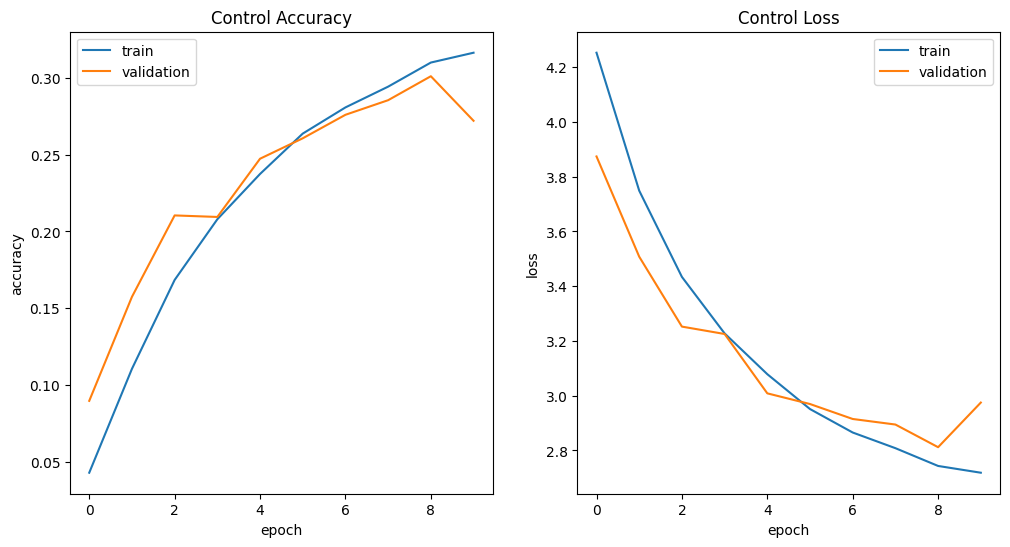

In [ ]:
plotModel(history1, "Control")

##Interpretation
We can see that with the Control Model (without Batch Normalization and Dropout) the result is pretty of moderate performance .

### Batch Normalization
Batch norm after convolutions and prior to activations.

In [ ]:
history2 = trainModel(batchNorm, 'models/batchNorm.h5')

Epoch 1/10
625/625 [==============================] - 18s 22ms/step - loss: 3.8469 - accuracy: 0.0996 - val_loss: 3.3223 - val_accuracy: 0.1866
Epoch 2/10
625/625 [==============================] - 14s 22ms/step - loss: 3.0980 - accuracy: 0.2211 - val_loss: 3.0073 - val_accuracy: 0.2410
Epoch 3/10
625/625 [==============================] - 13s 20ms/step - loss: 2.6458 - accuracy: 0.3109 - val_loss: 2.6089 - val_accuracy: 0.3239
Epoch 4/10
625/625 [==============================] - 13s 21ms/step - loss: 2.3628 - accuracy: 0.3703 - val_loss: 2.4537 - val_accuracy: 0.3518
Epoch 5/10
625/625 [==============================] - 12s 20ms/step - loss: 2.1635 - accuracy: 0.4145 - val_loss: 2.3002 - val_accuracy: 0.3923
Epoch 6/10
625/625 [==============================] - 12s 20ms/step - loss: 2.0020 - accuracy: 0.4530 - val_loss: 2.5590 - val_accuracy: 0.3645
Epoch 7/10
625/625 [==============================] - 12s 19ms/step - loss: 1.8708 - accuracy: 0.4849 - val_loss: 2.1689 - val_accuracy:

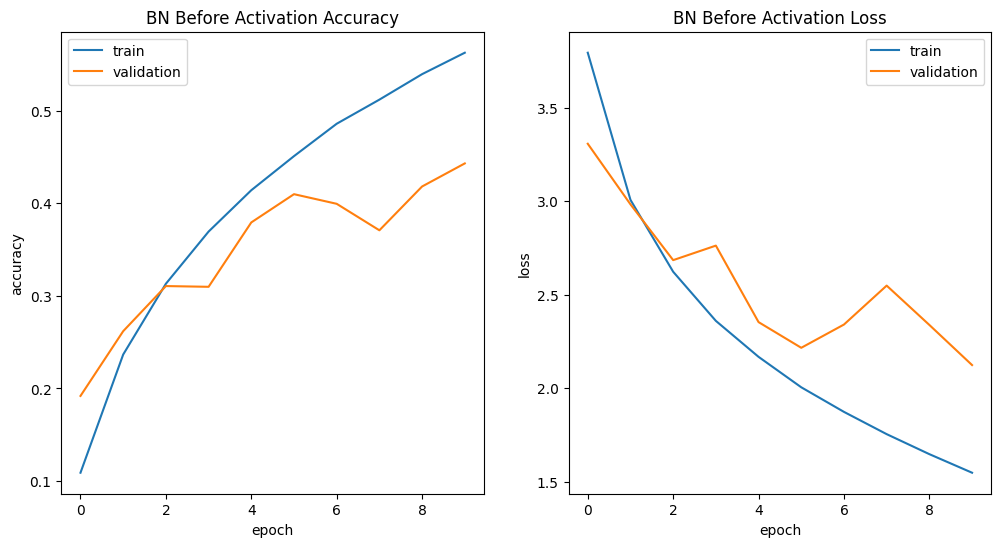

In [ ]:
plotModel(history2, "BN Before Activation")

**INTERPRETATION**

We can see with the batch normalization, the performance is still moderate, but better compare to the performance without it.


### Dropout 0.5
Dropout prior to activation with rate 0.5

In [ ]:
history3 = trainModel(dropout5, 'models/Dropout5.h5')

Epoch 1/10
625/625 [==============================] - 33s 33ms/step - loss: 4.7581 - accuracy: 0.0169 - val_loss: 4.6825 - val_accuracy: 0.0100
Epoch 2/10
  4/625 [..............................] - ETA: 11s - loss: 4.4875 - accuracy: 0.0188

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 16s 25ms/step - loss: 4.4308 - accuracy: 0.0230 - val_loss: 4.9621 - val_accuracy: 0.0100
Epoch 3/10
625/625 [==============================] - 13s 21ms/step - loss: 4.3872 - accuracy: 0.0235 - val_loss: 5.4087 - val_accuracy: 0.0100
Epoch 4/10
625/625 [==============================] - 13s 21ms/step - loss: 4.3632 - accuracy: 0.0250 - val_loss: 5.4039 - val_accuracy: 0.0100
Epoch 5/10
625/625 [==============================] - 13s 21ms/step - loss: 4.3426 - accuracy: 0.0262 - val_loss: 5.6881 - val_accuracy: 0.0101
Epoch 6/10
625/625 [==============================] - 13s 21ms/step - loss: 4.3290 - accuracy: 0.0285 - val_loss: 5.5590 - val_accuracy: 0.0097
Epoch 7/10
625/625 [==============================] - 13s 21ms/step - loss: 4.3356 - accuracy: 0.0294 - val_loss: 5.1565 - val_accuracy: 0.0104
Epoch 8/10
625/625 [==============================] - 13s 22ms/step - loss: 4.3407 - accuracy: 0.0306 - val_loss: 4.9771 - val_accuracy: 0.0121
Epo

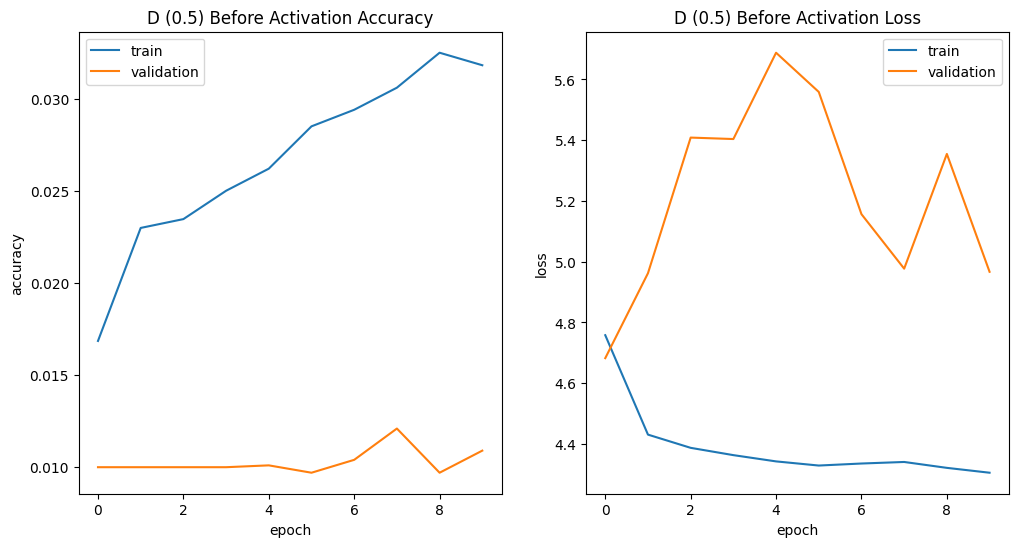

In [ ]:
plotModel(history3, "D (0.5) Before Activation")

**INTERPRETATION**

We can see the performance is very low, very very low, particulary for the validation data. And also the loss for the validation data, instead of becoming lower is upgrading. The dropout of 0.5 is clearly a failure

### Dropout 0.3
Dropout prior to activation with rate 0.3

In [ ]:
history4 = trainModel(dropout3 , 'models/Dropout3.h5')

Epoch 1/10
625/625 [==============================] - 18s 22ms/step - loss: 4.5097 - accuracy: 0.0181 - val_loss: 4.7330 - val_accuracy: 0.0109
Epoch 2/10
625/625 [==============================] - 13s 21ms/step - loss: 4.2471 - accuracy: 0.0365 - val_loss: 4.6396 - val_accuracy: 0.0240
Epoch 3/10
625/625 [==============================] - 13s 21ms/step - loss: 4.0701 - accuracy: 0.0612 - val_loss: 4.4781 - val_accuracy: 0.0367
Epoch 4/10
625/625 [==============================] - 13s 21ms/step - loss: 3.9656 - accuracy: 0.0777 - val_loss: 4.5439 - val_accuracy: 0.0441
Epoch 5/10
625/625 [==============================] - 13s 21ms/step - loss: 3.9006 - accuracy: 0.0871 - val_loss: 4.3845 - val_accuracy: 0.0454
Epoch 6/10
625/625 [==============================] - 14s 22ms/step - loss: 3.8615 - accuracy: 0.0945 - val_loss: 4.4269 - val_accuracy: 0.0384
Epoch 7/10
625/625 [==============================] - 14s 22ms/step - loss: 3.8196 - accuracy: 0.1019 - val_loss: 4.4451 - val_accuracy:

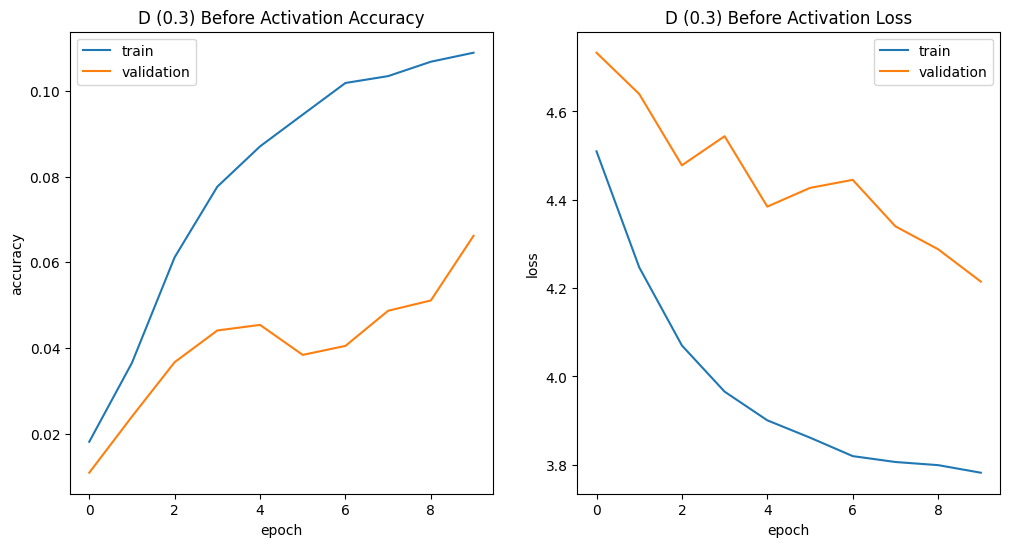

In [ ]:
plotModel(history4, "D (0.3) Before Activation")

**INTERPRETATION**

The performance are still very low, but are better than the previous one. And the loss curve are some way "normal", beacuse the are going down when the epoch increase. Dropout of 0.3 (before activation) is still a failure, but is more acceptable than 0.5

### Dropout 0.1
Dropout prior to activation with rate 0.1

In [ ]:
history5 = trainModel(dropout1, 'models/Dropout1.h5')

Epoch 1/10
625/625 [==============================] - 16s 22ms/step - loss: 4.3852 - accuracy: 0.0263 - val_loss: 4.0390 - val_accuracy: 0.0630
Epoch 2/10
625/625 [==============================] - 16s 25ms/step - loss: 3.9428 - accuracy: 0.0772 - val_loss: 3.8380 - val_accuracy: 0.0999
Epoch 3/10
625/625 [==============================] - 16s 25ms/step - loss: 3.6723 - accuracy: 0.1272 - val_loss: 3.5579 - val_accuracy: 0.1626
Epoch 4/10
625/625 [==============================] - 14s 22ms/step - loss: 3.4923 - accuracy: 0.1582 - val_loss: 3.4469 - val_accuracy: 0.1723
Epoch 5/10
625/625 [==============================] - 13s 21ms/step - loss: 3.3602 - accuracy: 0.1825 - val_loss: 3.3154 - val_accuracy: 0.1930
Epoch 6/10
625/625 [==============================] - 14s 22ms/step - loss: 3.2699 - accuracy: 0.2018 - val_loss: 3.2022 - val_accuracy: 0.2220
Epoch 7/10
625/625 [==============================] - 14s 22ms/step - loss: 3.2003 - accuracy: 0.2127 - val_loss: 3.1796 - val_accuracy:

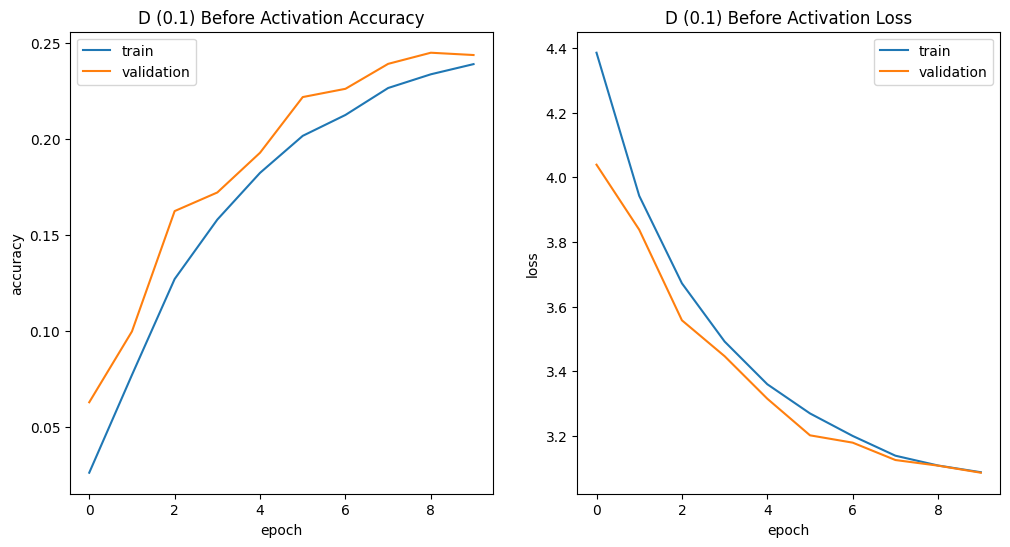

In [ ]:
plotModel(history5, "D (0.1) Before Activation")

**INTERPRETATION**
The performance are moderate, but is the best among the dropout rate

### Performance of BN and Dropout before activations
Plot  the performance (accuracies and losses) of all 5 models plotted together.

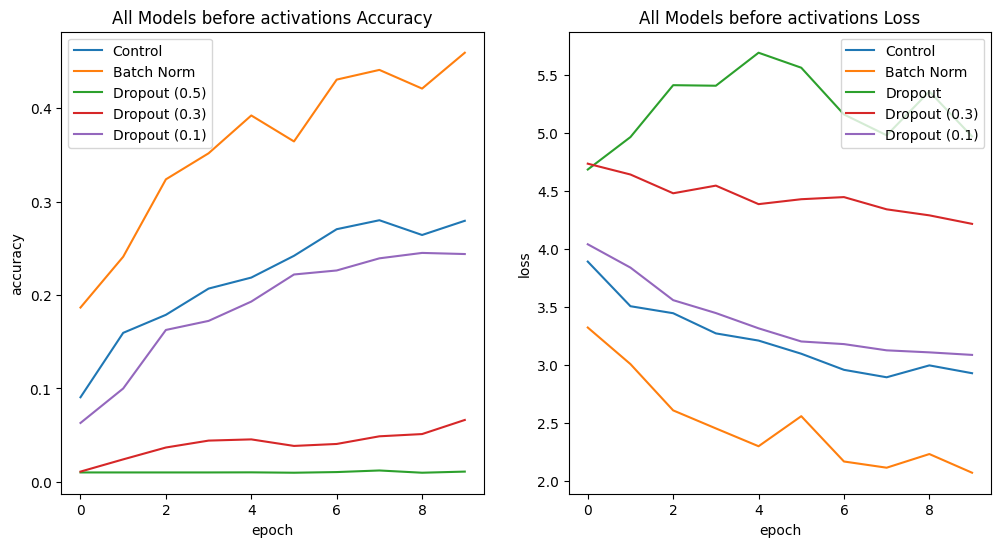

In [ ]:
plotAllModels(history1, history2, history3, history4, history5, "All Models before activations")

##What is your conclusion from the first build ?

The best thing do to optimize our model  is to apply batch normalization, instead of dropout. And if we want to use the dropout, we should go a very low rate to have something convenient.
Let's see when we apply after the activation


# Let's try Dropout and Batch norm after activations

## Model Construction

Rebuild the same blocks, changing the order of BN and Dropout operations to be after activation function

In [ ]:
def input_conv_block(model, bn=False, dropout=False, rate=0.4, activation="relu"):
    """
    The first convolutional block in each architecture. Seperated so we can
    specify the input shape.
    """
    model.add(Conv2D(60,3, padding = "same", input_shape = x_train.shape[1:]))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))

    model.add(Conv2D(60,3, padding = "same"))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))


    model.add(MaxPooling2D())
    return model

def conv_block(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    Generic convolutional block with 2 stacked 3x3 convolutions, max pooling, dropout,
    and an optional Batch Normalization.
    """
    model.add(Conv2D(60,3, padding = "same"))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))

    model.add(Conv2D(60,3, padding = "same"))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))
    model.add(MaxPooling2D())
    return model


def conv_block_final(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    I bumped up the number of filters in the final block. I made this seperate so that
    I might be able to integrate Global Average Pooling later on.
    """
    model.add(Conv2D(100,3, padding = "same"))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))


    model.add(Conv2D(100,3, padding = "same"))
    model.add(Activation(activation))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))


    model.add(Flatten())
    return model

def fn_block(model):

    model.add(Dense(1000, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = "softmax"))

    return model

def build_model(blocks=3, bn=False, dropout=False, rate=0.5, activation = "relu"):

    model = Sequential()

    model = input_conv_block(model, bn=bn, dropout=dropout, rate=rate, activation=activation)

    for block in range(1,blocks-1):
        model = conv_block(model, bn=bn, dropout=dropout, rate=rate, activation = activation)

    model = conv_block_final(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    model = fn_block(model)

    return model

def compile_model(model, optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]):

    model.compile(optimizer = optimizer,
                 loss = loss,
                 metrics = metrics)
    return model

### Compile the Models

In [ ]:
control = build_model(blocks = 5, bn=False, dropout=False, activation = "relu")
control = compile_model(control)

batchNorm = build_model(blocks = 5, bn=True, dropout=False, activation = "relu")
batchNorm = compile_model(batchNorm)

dropout5 = build_model(blocks = 5, bn=False, dropout=True,rate = 0.5, activation = "relu")
dropout5 = compile_model(dropout5)

dropout3 = build_model(blocks = 5, bn=False, dropout=True,rate = 0.3, activation = "relu")
dropout3 = compile_model(dropout3)

dropout1 = build_model(blocks = 5, bn=False, dropout=True,rate = 0.1, activation = "relu")
dropout1 = compile_model(dropout1)

## Training the Models

### Control

In [ ]:
history6 = trainModel(control, 'models/control.h5')

Epoch 1/10
625/625 [==============================] - 13s 18ms/step - loss: 4.2557 - accuracy: 0.0423 - val_loss: 3.8676 - val_accuracy: 0.0855
Epoch 2/10
  5/625 [..............................] - ETA: 9s - loss: 3.9356 - accuracy: 0.0675 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 10s 16ms/step - loss: 3.7515 - accuracy: 0.1142 - val_loss: 3.5040 - val_accuracy: 0.1586
Epoch 3/10
625/625 [==============================] - 10s 15ms/step - loss: 3.4539 - accuracy: 0.1693 - val_loss: 3.2857 - val_accuracy: 0.1994
Epoch 4/10
625/625 [==============================] - 10s 16ms/step - loss: 3.2503 - accuracy: 0.2052 - val_loss: 3.1295 - val_accuracy: 0.2306
Epoch 5/10
625/625 [==============================] - 10s 16ms/step - loss: 3.1015 - accuracy: 0.2356 - val_loss: 3.1026 - val_accuracy: 0.2349
Epoch 6/10
625/625 [==============================] - 10s 16ms/step - loss: 2.9861 - accuracy: 0.2598 - val_loss: 3.0850 - val_accuracy: 0.2454
Epoch 7/10
625/625 [==============================] - 10s 16ms/step - loss: 2.8923 - accuracy: 0.2780 - val_loss: 3.0408 - val_accuracy: 0.2570
Epoch 8/10
625/625 [==============================] - 10s 16ms/step - loss: 2.8202 - accuracy: 0.2921 - val_loss: 2.9137 - val_accuracy: 0.2724
Epo

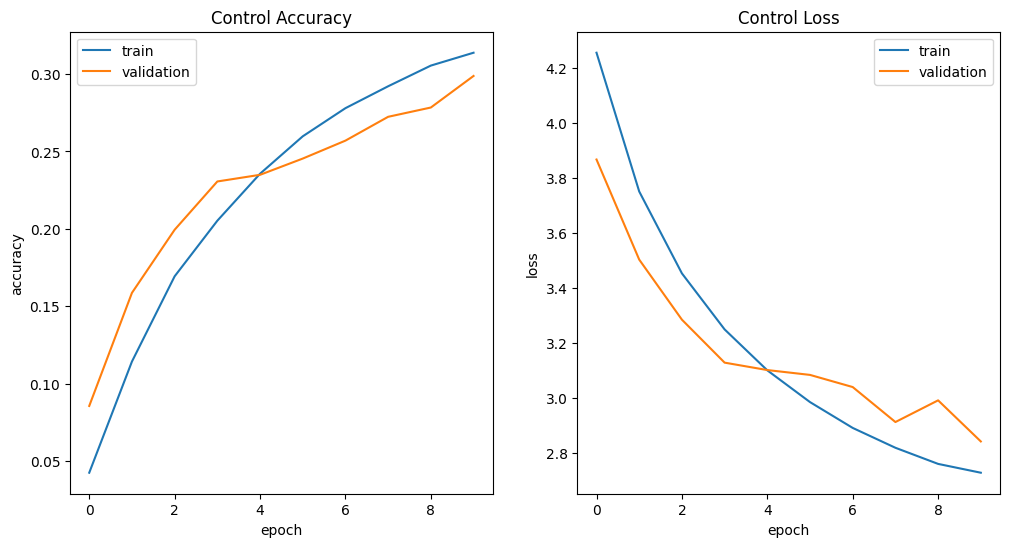

In [ ]:
plotModel(history6, "Control")

### Batch Norm

In [ ]:
history7 = trainModel(batchNorm, 'models/batchNorm.h5')

Epoch 1/10
625/625 [==============================] - 17s 20ms/step - loss: 3.8149 - accuracy: 0.1148 - val_loss: 3.4086 - val_accuracy: 0.1752
Epoch 2/10
625/625 [==============================] - 12s 19ms/step - loss: 3.0850 - accuracy: 0.2268 - val_loss: 3.1149 - val_accuracy: 0.2663
Epoch 3/10
625/625 [==============================] - 12s 19ms/step - loss: 2.7000 - accuracy: 0.3053 - val_loss: 2.5139 - val_accuracy: 0.3421
Epoch 4/10
625/625 [==============================] - 12s 19ms/step - loss: 2.4567 - accuracy: 0.3533 - val_loss: 2.4721 - val_accuracy: 0.3628
Epoch 5/10
625/625 [==============================] - 12s 19ms/step - loss: 2.2723 - accuracy: 0.3960 - val_loss: 2.3071 - val_accuracy: 0.3946
Epoch 6/10
625/625 [==============================] - 12s 19ms/step - loss: 2.1190 - accuracy: 0.4295 - val_loss: 2.2160 - val_accuracy: 0.4229
Epoch 7/10
625/625 [==============================] - 12s 19ms/step - loss: 1.9969 - accuracy: 0.4587 - val_loss: 2.2001 - val_accuracy:

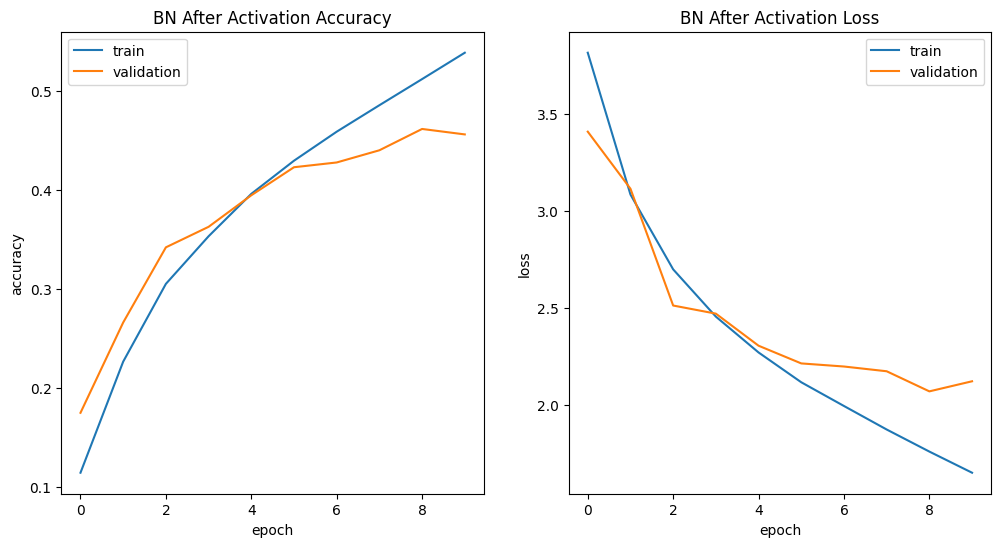

In [ ]:
plotModel(history7, "BN After Activation")

**INTERPRETATION**
The performance are better than the models without batch normalization. BN has help to optimize the model.

### Dropout 0.5

In [ ]:
history8 = trainModel(dropout5, 'models/Dropout5.h5')

Epoch 1/10
625/625 [==============================] - 16s 22ms/step - loss: 4.7523 - accuracy: 0.0159 - val_loss: 4.6953 - val_accuracy: 0.0100
Epoch 2/10
625/625 [==============================] - 13s 21ms/step - loss: 4.4216 - accuracy: 0.0224 - val_loss: 5.0153 - val_accuracy: 0.0100
Epoch 3/10
625/625 [==============================] - 16s 25ms/step - loss: 4.3849 - accuracy: 0.0242 - val_loss: 5.4021 - val_accuracy: 0.0100
Epoch 4/10
625/625 [==============================] - 13s 21ms/step - loss: 4.3539 - accuracy: 0.0260 - val_loss: 5.5763 - val_accuracy: 0.0100
Epoch 5/10
625/625 [==============================] - 13s 21ms/step - loss: 4.3423 - accuracy: 0.0293 - val_loss: 5.5422 - val_accuracy: 0.0092
Epoch 6/10
625/625 [==============================] - 13s 20ms/step - loss: 4.3392 - accuracy: 0.0272 - val_loss: 5.4329 - val_accuracy: 0.0105
Epoch 7/10
625/625 [==============================] - 15s 25ms/step - loss: 4.3248 - accuracy: 0.0303 - val_loss: 5.0605 - val_accuracy:

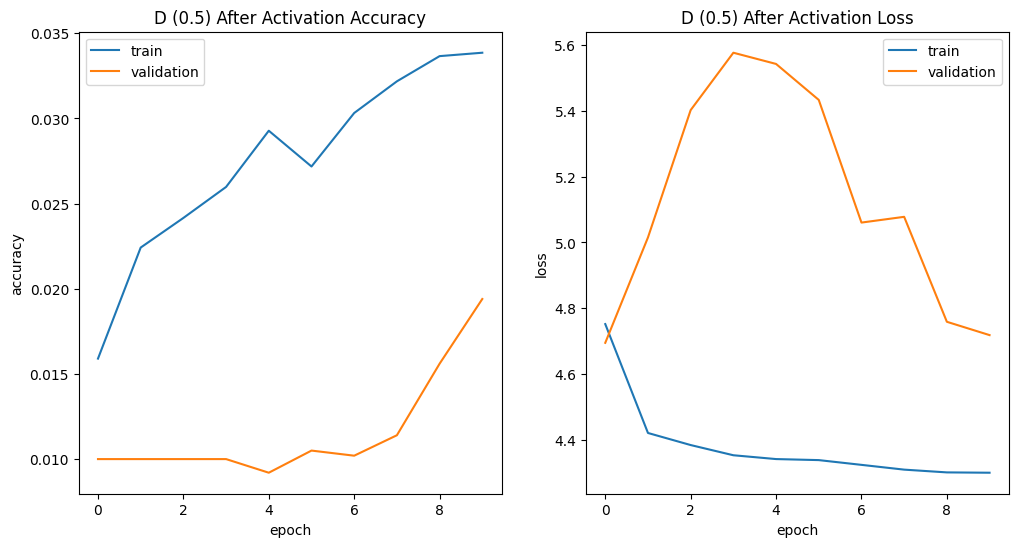

In [ ]:
plotModel(history8, "D (0.5) After Activation")

**INTERPRETATION**
(Approximativaley) Same as the case when we apply before activation

### Dropout 0.3

In [ ]:
history9 = trainModel(dropout3, 'models/Dropout3.h5')

Epoch 1/10
625/625 [==============================] - 18s 24ms/step - loss: 4.5113 - accuracy: 0.0219 - val_loss: 4.4461 - val_accuracy: 0.0354
Epoch 2/10
625/625 [==============================] - 13s 20ms/step - loss: 4.1461 - accuracy: 0.0504 - val_loss: 4.4631 - val_accuracy: 0.0267
Epoch 3/10
625/625 [==============================] - 13s 20ms/step - loss: 4.0019 - accuracy: 0.0697 - val_loss: 4.3864 - val_accuracy: 0.0414
Epoch 4/10
625/625 [==============================] - 15s 23ms/step - loss: 3.9280 - accuracy: 0.0858 - val_loss: 4.3744 - val_accuracy: 0.0502
Epoch 5/10
625/625 [==============================] - 15s 24ms/step - loss: 3.8822 - accuracy: 0.0922 - val_loss: 4.2856 - val_accuracy: 0.0566
Epoch 6/10
625/625 [==============================] - 14s 22ms/step - loss: 3.8445 - accuracy: 0.1023 - val_loss: 4.3127 - val_accuracy: 0.0507
Epoch 7/10
625/625 [==============================] - 14s 22ms/step - loss: 3.8189 - accuracy: 0.1050 - val_loss: 4.3559 - val_accuracy:

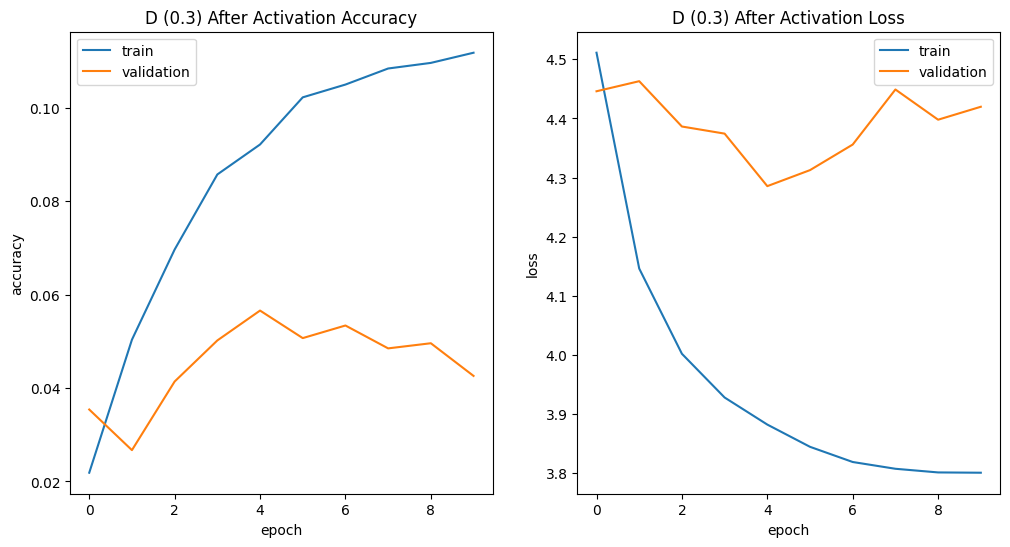

In [ ]:
plotModel(history9, "D (0.3) After Activation")

**INTERPRETATION**
Approximativaly same as with the case when we make the dropout before the activation. The difference is with the loss (not "normal") on the validation data

### Dropout 0.1

In [ ]:
history10 = trainModel(dropout1, 'models/Dropout1.h5')

Epoch 1/10
625/625 [==============================] - 17s 23ms/step - loss: 4.4378 - accuracy: 0.0255 - val_loss: 4.1408 - val_accuracy: 0.0545
Epoch 2/10
625/625 [==============================] - 13s 20ms/step - loss: 4.0256 - accuracy: 0.0688 - val_loss: 3.9593 - val_accuracy: 0.0890
Epoch 3/10
625/625 [==============================] - 13s 21ms/step - loss: 3.7554 - accuracy: 0.1105 - val_loss: 3.7024 - val_accuracy: 0.1305
Epoch 4/10
625/625 [==============================] - 13s 20ms/step - loss: 3.5621 - accuracy: 0.1433 - val_loss: 3.6099 - val_accuracy: 0.1387
Epoch 5/10
625/625 [==============================] - 13s 20ms/step - loss: 3.4237 - accuracy: 0.1716 - val_loss: 3.3519 - val_accuracy: 0.1889
Epoch 6/10
625/625 [==============================] - 14s 22ms/step - loss: 3.3290 - accuracy: 0.1886 - val_loss: 3.2674 - val_accuracy: 0.2065
Epoch 7/10
625/625 [==============================] - 13s 21ms/step - loss: 3.2499 - accuracy: 0.2057 - val_loss: 3.3202 - val_accuracy:

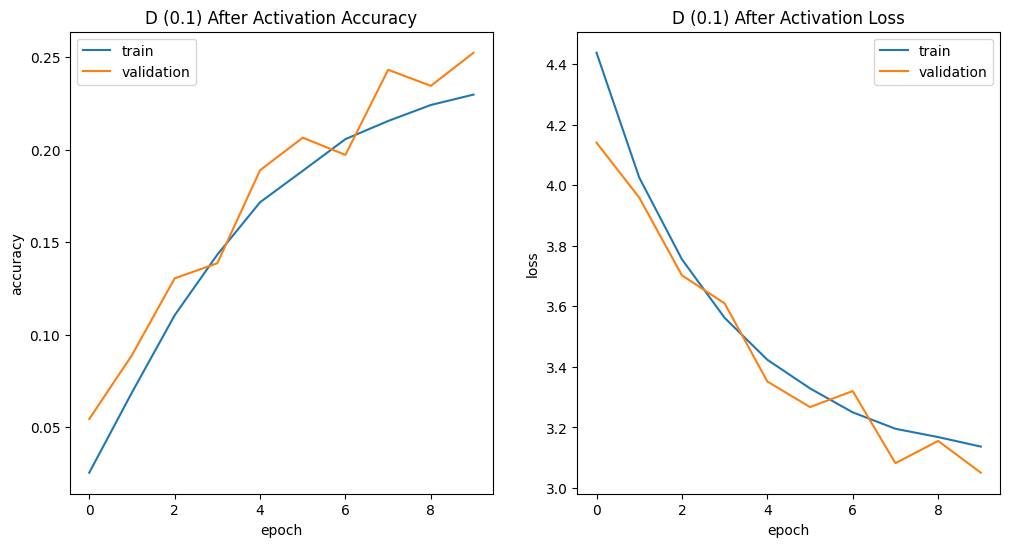

In [ ]:
plotModel(history10, "D (0.1) After Activation")

**Same**

### Performance of BN and Dropout after activations
Plot the performances (accuracies and loss ) of all models together

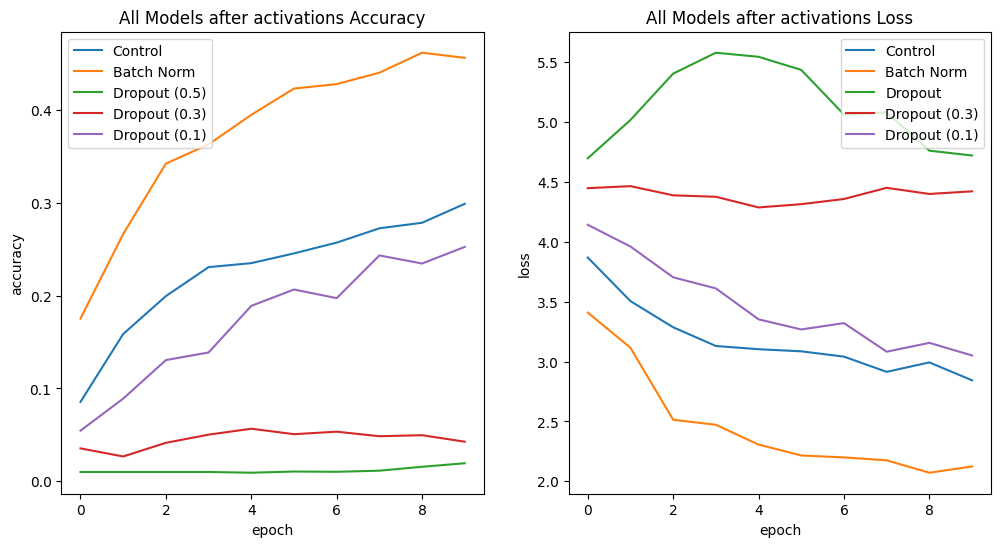

In [ ]:
plotAllModels(history6, history7, history8, history9, history10, "All Models after activations")

**The result is some way the same with the previous case. In fact, we can deduce that applying the batch normalization before or after the activation function doesn't make big differences**

# Let's try to add BN and Dropout after maxpooling?
Rebuild the same blocks, changing the order of BN and Dropout operations to be after Maxpooling
## Model Construction

In [ ]:
def input_conv_block(model, bn=False, dropout=False, rate=0.4, activation="relu"):
    """
    The first convolutional block in each architecture. Seperated so we can
    specify the input shape.
    """
    model.add(Conv2D(60,3, padding = "same", input_shape = x_train.shape[1:]))

    model.add(Activation(activation))

    model.add(Conv2D(60,3, padding = "same"))

    model.add(Activation(activation))

    model.add(MaxPooling2D())
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))

    return model

def conv_block(model, bn=False, dropout=False, rate=0.5, activation = "relu"):

    """
    Generic convolutional block with 2 stacked 3x3 convolutions, max pooling, dropout,
    and an optional Batch Normalization.
    """
    model.add(Conv2D(60,3, padding = "same"))
    model.add(Activation(activation))

    model.add(Conv2D(60,3, padding = "same"))
    model.add(Activation(activation))

    model.add(MaxPooling2D())
    if bn:
      model.add(BatchNormalization())
    if dropout:
      model.add(Dropout(rate))
    return model



def conv_block_final(model, bn=False, dropout=False, rate=0.5, activation = "relu"):
    """
    I bumped up the number of filters in the final block. I made this seperate so that
    I might be able to integrate Global Average Pooling later on.
    """
    model.add(Conv2D(100,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))
    model.add(Activation(activation))

    model.add(Conv2D(100,3, padding = "same"))
    if bn:
        model.add(BatchNormalization())
    if dropout:
        model.add(Dropout(rate))
    model.add(Activation(activation))

    model.add(Flatten())
    return model

def fn_block(model):

    model.add(Dense(1000, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation = "softmax"))


    return model

def build_model(blocks=3, bn=False, dropout=False, rate=0.5, activation = "relu"):

    model = Sequential()

    model = input_conv_block(model, bn=bn, dropout=dropout, rate=rate, activation=activation)

    for block in range(1,blocks-1):
        model = conv_block(model, bn=bn, dropout=dropout, rate=rate, activation = activation)

    model = conv_block_final(model, bn=bn, dropout=dropout, rate=rate, activation=activation)
    model = fn_block(model)

    return model

def compile_model(model, optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"]):

    model.compile(optimizer = optimizer,
                 loss = loss,
                 metrics = metrics)
    return model


### Compile the models.

In [ ]:
control = build_model(blocks = 5, bn=False, dropout=False, activation = "relu")
control = compile_model(control)

batchNorm = build_model(blocks = 5, bn=True, dropout=False, activation = "relu")
batchNorm = compile_model(batchNorm)

dropout5 = build_model(blocks = 5, bn=False, dropout=True, rate = 0.5, activation = "relu")
dropout5 = compile_model(dropout5)

dropout3 = build_model(blocks = 5, bn=False, dropout=True,rate = 0.3, activation = "relu")
dropout3 = compile_model(dropout3)

dropout1 = build_model(blocks = 5, bn=False, dropout=True,rate = 0.1, activation = "relu")
dropout1 = compile_model(dropout1)

## Train the models.

### Control Model

In [ ]:
history11 = trainModel(control, 'models/control.h5')

Epoch 1/10
625/625 [==============================] - 13s 18ms/step - loss: 4.2876 - accuracy: 0.0367 - val_loss: 4.1881 - val_accuracy: 0.0615
Epoch 2/10
625/625 [==============================] - 10s 15ms/step - loss: 3.8282 - accuracy: 0.0977 - val_loss: 3.6114 - val_accuracy: 0.1392
Epoch 3/10
625/625 [==============================] - 10s 16ms/step - loss: 3.5180 - accuracy: 0.1573 - val_loss: 3.3448 - val_accuracy: 0.1856
Epoch 4/10
625/625 [==============================] - 10s 16ms/step - loss: 3.2650 - accuracy: 0.2019 - val_loss: 3.2090 - val_accuracy: 0.2146
Epoch 5/10
625/625 [==============================] - 10s 16ms/step - loss: 3.0917 - accuracy: 0.2329 - val_loss: 3.0224 - val_accuracy: 0.2492
Epoch 6/10
625/625 [==============================] - 10s 16ms/step - loss: 2.9683 - accuracy: 0.2585 - val_loss: 3.0357 - val_accuracy: 0.2458
Epoch 7/10
625/625 [==============================] - 10s 15ms/step - loss: 2.8606 - accuracy: 0.2827 - val_loss: 2.9459 - val_accuracy:

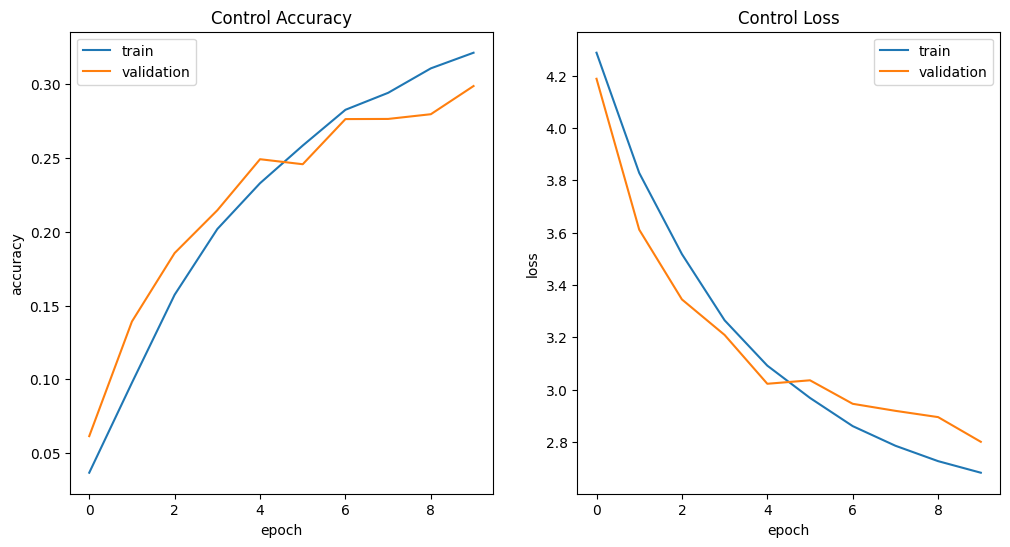

In [ ]:
plotModel(history11, "Control")

### Batch Norm

In [ ]:
history12 = trainModel(batchNorm, 'models/batchNorm.h5')

Epoch 1/10
625/625 [==============================] - 15s 19ms/step - loss: 3.7670 - accuracy: 0.1210 - val_loss: 3.3641 - val_accuracy: 0.1855
Epoch 2/10
625/625 [==============================] - 11s 18ms/step - loss: 3.0038 - accuracy: 0.2410 - val_loss: 2.7842 - val_accuracy: 0.2841
Epoch 3/10
625/625 [==============================] - 11s 17ms/step - loss: 2.5941 - accuracy: 0.3228 - val_loss: 2.5493 - val_accuracy: 0.3385
Epoch 4/10
625/625 [==============================] - 11s 17ms/step - loss: 2.3261 - accuracy: 0.3823 - val_loss: 2.4844 - val_accuracy: 0.3585
Epoch 5/10
625/625 [==============================] - 14s 22ms/step - loss: 2.1189 - accuracy: 0.4266 - val_loss: 2.2735 - val_accuracy: 0.4035
Epoch 6/10
625/625 [==============================] - 14s 22ms/step - loss: 1.9573 - accuracy: 0.4646 - val_loss: 2.2573 - val_accuracy: 0.4164
Epoch 7/10
625/625 [==============================] - 12s 19ms/step - loss: 1.8145 - accuracy: 0.4975 - val_loss: 2.1622 - val_accuracy:

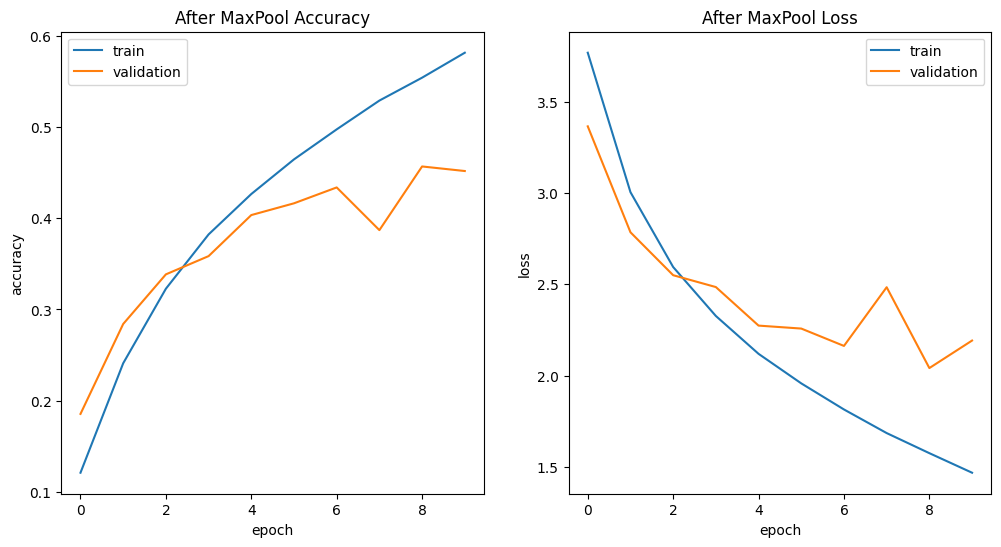

In [ ]:
plotModel(history12, "After MaxPool")

**The result is moderate, but is higher than the two previous first use case**

### Dropout 0.5

In [ ]:
history13 = trainModel(dropout5, 'models/Dropout5.h5')

Epoch 1/10
625/625 [==============================] - 15s 20ms/step - loss: 4.5159 - accuracy: 0.0175 - val_loss: 4.7776 - val_accuracy: 0.0100
Epoch 2/10
625/625 [==============================] - 11s 18ms/step - loss: 4.3836 - accuracy: 0.0217 - val_loss: 4.6459 - val_accuracy: 0.0125
Epoch 3/10
625/625 [==============================] - 12s 18ms/step - loss: 4.3088 - accuracy: 0.0268 - val_loss: 4.6607 - val_accuracy: 0.0143
Epoch 4/10
625/625 [==============================] - 11s 18ms/step - loss: 4.2583 - accuracy: 0.0311 - val_loss: 4.5539 - val_accuracy: 0.0205
Epoch 5/10
625/625 [==============================] - 12s 20ms/step - loss: 4.2166 - accuracy: 0.0362 - val_loss: 4.5018 - val_accuracy: 0.0257
Epoch 6/10
625/625 [==============================] - 12s 19ms/step - loss: 4.1693 - accuracy: 0.0424 - val_loss: 4.4414 - val_accuracy: 0.0266
Epoch 7/10
625/625 [==============================] - 11s 18ms/step - loss: 4.1357 - accuracy: 0.0495 - val_loss: 4.4346 - val_accuracy:

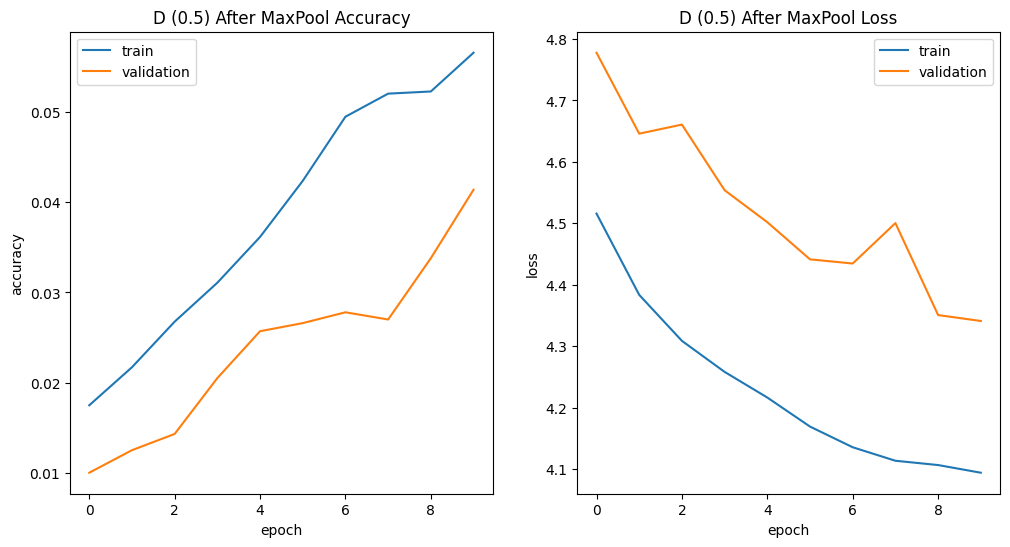

In [ ]:
plotModel(history13, "D (0.5) After MaxPool")

**The result is very very low. But in comparaison with the other past two use cases, the plot are more conventional. In fact, the accuracy upgrade and the loss diminish when the epoch upgrade**

### Dropout 0.3

In [ ]:
history14 = trainModel(dropout3, 'models/Dropout3.h5')

Epoch 1/10
625/625 [==============================] - 15s 20ms/step - loss: 4.4416 - accuracy: 0.0205 - val_loss: 4.3330 - val_accuracy: 0.0255
Epoch 2/10
625/625 [==============================] - 12s 19ms/step - loss: 4.1584 - accuracy: 0.0466 - val_loss: 4.0181 - val_accuracy: 0.0698
Epoch 3/10
625/625 [==============================] - 12s 18ms/step - loss: 3.9751 - accuracy: 0.0730 - val_loss: 3.9514 - val_accuracy: 0.0898
Epoch 4/10
625/625 [==============================] - 11s 18ms/step - loss: 3.8405 - accuracy: 0.0961 - val_loss: 3.6776 - val_accuracy: 0.1231
Epoch 5/10
625/625 [==============================] - 11s 18ms/step - loss: 3.7279 - accuracy: 0.1144 - val_loss: 3.5678 - val_accuracy: 0.1509
Epoch 6/10
625/625 [==============================] - 11s 18ms/step - loss: 3.6598 - accuracy: 0.1249 - val_loss: 3.5272 - val_accuracy: 0.1541
Epoch 7/10
625/625 [==============================] - 11s 18ms/step - loss: 3.6125 - accuracy: 0.1339 - val_loss: 3.4730 - val_accuracy:

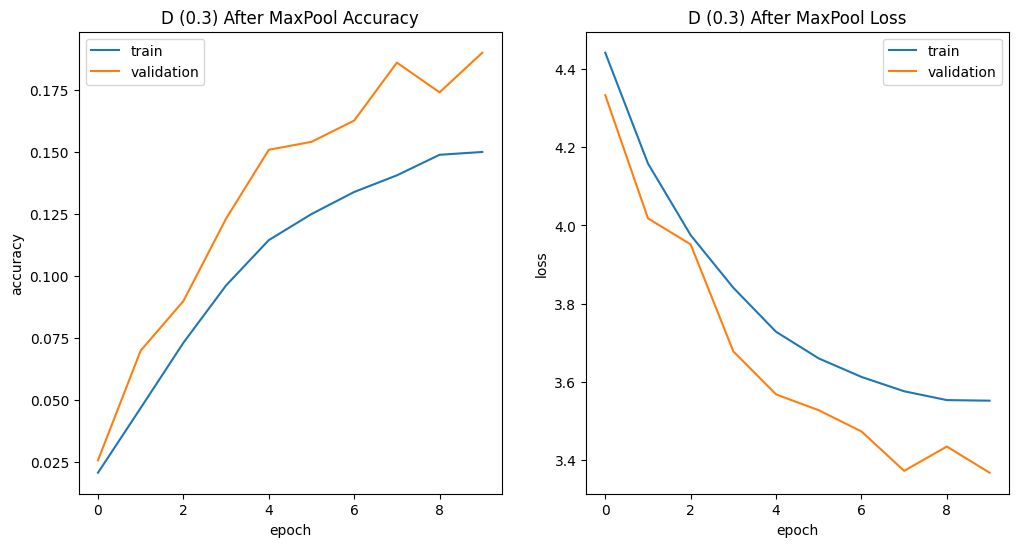

In [ ]:
plotModel(history14, "D (0.3) After MaxPool")

### Dropout 0.1

In [ ]:
history15 = trainModel(dropout1, 'models/Dropout1.h5')

Epoch 1/10
625/625 [==============================] - 15s 20ms/step - loss: 4.3715 - accuracy: 0.0290 - val_loss: 4.0175 - val_accuracy: 0.0622
Epoch 2/10
625/625 [==============================] - 11s 18ms/step - loss: 3.9259 - accuracy: 0.0773 - val_loss: 3.7057 - val_accuracy: 0.1115
Epoch 3/10
625/625 [==============================] - 12s 19ms/step - loss: 3.6605 - accuracy: 0.1236 - val_loss: 3.4243 - val_accuracy: 0.1693
Epoch 4/10
625/625 [==============================] - 11s 18ms/step - loss: 3.4515 - accuracy: 0.1628 - val_loss: 3.2828 - val_accuracy: 0.1898
Epoch 5/10
625/625 [==============================] - 14s 22ms/step - loss: 3.3151 - accuracy: 0.1882 - val_loss: 3.2355 - val_accuracy: 0.2081
Epoch 6/10
625/625 [==============================] - 13s 21ms/step - loss: 3.2123 - accuracy: 0.2084 - val_loss: 3.0398 - val_accuracy: 0.2438
Epoch 7/10
625/625 [==============================] - 13s 21ms/step - loss: 3.1409 - accuracy: 0.2232 - val_loss: 2.9958 - val_accuracy:

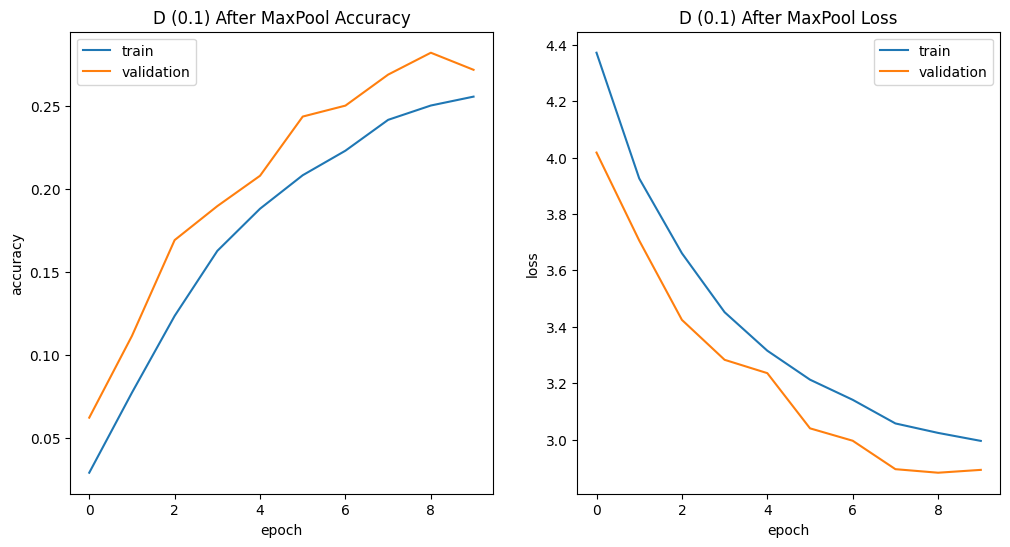

In [ ]:
plotModel(history15, "D (0.1) After MaxPool")

### Performance of BN and Dropout after maxpooling

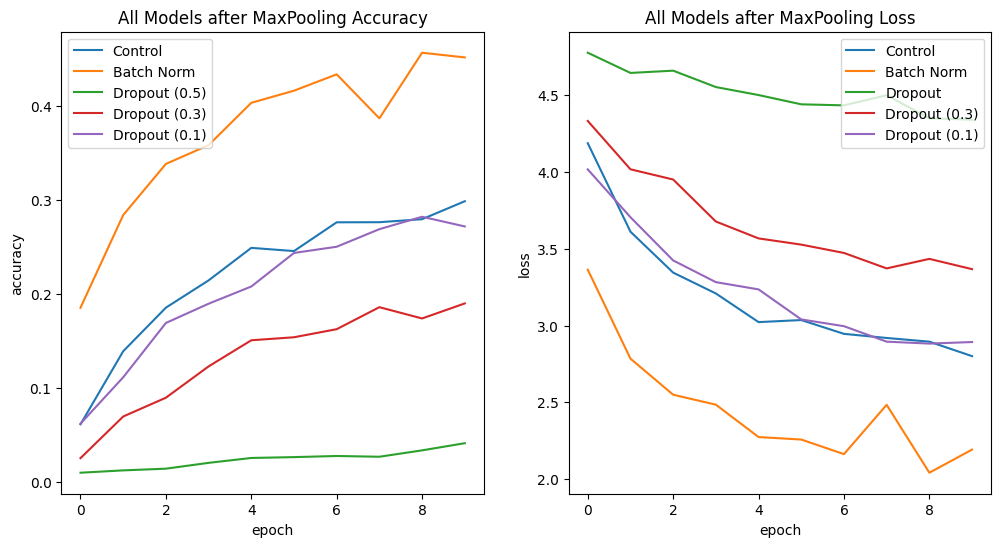

In [ ]:
plotAllModels(history11, history12, history13, history14, history15, "All Models after MaxPooling")

**The batch normalization is still the winner, and the conclusion seems to be the same than the two previous use case. Batch normalization is a better way to optimize the models, and the dropout is more efficient with lower rate. The particulary of applying batch normalization or dropout after the maxpooling can be that by doing that, the apparences of the curves are more conventional**

  **Conclusion**: Yes, batch normalization has provide better result in each case, and the dropout have give us some acceptable (they still very low and inferior  to the performance with the "control" model) results when they are applied with the lowest rate. For our cases, dropout is clearly a thing to not do